In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random
from math import sqrt
from tqdm import tqdm
from copy import deepcopy

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
start_hour = 5
end_hour = 10

In [4]:
meta = pd.read_csv('calibration_data/Traffic_Counts_by_Study_20240122.csv')
hourly_data = pd.read_csv('calibration_data/Traffic_Count_Studies_by_Hour_Bins_20240122.csv')

In [5]:
demand_data = pd.read_csv('psrc_vehicle_trips_converted_taz_calibrated.csv')  # Use after making changes in step2


FileNotFoundError: [Errno 2] No such file or directory: 'psrc_vehicle_trips_converted_taz_calibrated.csv'

In [5]:
# used for count studies data processing
cols_to_keep = ['STUDY_ID','TOTAL',
                'HR01_TOTAL', 'HR02_TOTAL', 'HR03_TOTAL', 'HR04_TOTAL', 'HR05_TOTAL',
               'HR06_TOTAL', 'HR07_TOTAL', 'HR08_TOTAL', 'HR09_TOTAL', 'HR10_TOTAL',
               'HR11_TOTAL', 'HR12_TOTAL', 'HR13_TOTAL', 'HR14_TOTAL', 'HR15_TOTAL',
               'HR16_TOTAL', 'HR17_TOTAL', 'HR18_TOTAL', 'HR19_TOTAL', 'HR20_TOTAL',
               'HR21_TOTAL', 'HR22_TOTAL', 'HR23_TOTAL', 'HR24_TOTAL', 'AM_PK_VOL',
               'AM_PK_HOUR', 'AM_PK_FAC', 'AM_15_HIGH', 'PM_PK_VOL', 'PM_PK_HOUR',
               'PM_PK_FAC', 'PM_15_HIGH', 'MAX_8_VOL', 'MAX_8_TIME', 'MAX_8_FAC']
agg_func = {col:((lambda x: x.mode().iloc[0]) if col[-4:] in ['TIME', 'HOUR', 'HIGH'] else 'mean') for col in cols_to_keep}

### Finding useful studies

### count studies should be doubled check

In [6]:
## look at previous sections for title of each studyID

## for inflow to the network
demand_study_dict_origin = {6001: [322483],
             7000: [333868, 320924, 324519, 318994],
             7001: [322813, 324362, 331428, 332269], 
             7002: [332512, 320510, 320532, 324825],  
             7003: [332184, 332592, 323870, 328373, 328365, 328363], 
             7004: [329133, 326627, 332936, 333111, 332535], 
             7005: [321422, 320154, 329144, 327226, 329133]}

    
## for outflow of the network
demand_study_dict_dest = {6001: [322482],
             7000: [333869, 330820, 324302, 318995],
             7001: [322812, 324361, 331427, 332265],  
             7002: [324827, 320531, 320509, 332512, 321121],
             7003: [332195, 332594, 314796, 323869, 328371, 328362], 
             7004: [331094, 326626, 332940, 333110, 332536], 
             7005: [321116, 320155, 329142, 327225, 331094]}


corridor_study_dict = {'denny_e1': 327937,  'denny_e2': 332405,  'denny_e3': 332485,  
                       'denny_w3': 327938,  'denny_w2':332404,'denny_w1': 332486, 
                       'yesler_e2':326650, 'yesler_e1':329389, 'yesler_w1':326651, 'yesler_w2':329391,
                       'boren_se1':332078, 'boren_se2':332747, 'boren_se3':332082, 
                       'boren_nw3':332077, 'boren_nw2':332876, 'boren_nw1':332081, 
                       'pine_e1':328588, 'pine_e2':330544, 'pine_w1':330545, 'pine_w2':328589,'pine_w3':331119, 
                       'stewart_w1':327941, 'seven_n1':332787, 'seven_s1':332788, 
                       'first_se3': 332062, 'first_se2': 332029, 'first_se1': 330712, 
                       'first_nw3': 330717, 'first_nw2': 332030 ,'first_nw1': 332063}



# draw barplots for real and simulation data

### define functions

In [7]:
def get_period_stats(observation_simulation_pairs):
    '''
    checking GEH and flow validation (options i, ii, iii, and v in the criteria table)
    '''
    # in this function, we calculate GEH for selected period and check other criteria for calibration
#     validation_dict = {key:[], for key in observation_simulation_pairs.keys()}
    GEHs = {}
    flow_validation = {}
    gehU5, gehU10, gehU15 = 0, 0, 0


    for key,pair in observation_simulation_pairs.items():
        field = pair[0]
        model = pair[1]
        # check GEH
        GEH = sqrt(2*((model-field)**2)/(model+field))
        GEHs[key] = GEH
        if GEH<=15:
            gehU15+=1
        if GEH<=10:
            gehU10+=1
        if GEH<=5:
            gehU5+=1

        # check hourly flow 
        valid_flow = False
        difference = abs(model-field)
        if field<700:  # option a.i
            if difference<=100:
                valid_flow=True
        elif field<2700:  # option a.ii
            if difference<=0.15*field:
                valid_flow=True
        elif field>=2700:  # option a.iii
            if difference<=400:
                valid_flow=True
        flow_validation[key] = valid_flow            
#     return [GEHs, flow_validation, gehU15, gehU10, gehU5]
    n = len(observation_simulation_pairs)
    return f'valid flows: {sum(list(flow_validation.values()))}/{n} \nGEHs under 5: {gehU5}/{n} \nGEHs under 10: {gehU10}/{n} \nGEHs under 15: {gehU15}/{n}' 

In [8]:
def get_GEH(field_dict, model_dict, start_end = None):
    '''
    given hourly volumes of observation and simulation,
    this function gives us GEH for each hour, selected period, and all given hours 
    '''
    ans = {'hourly':{}, 'total':None, 'period':None, 'period_hours':{}}
    period_validation_stats = None
    
    period_real_sim_pairs = {}
    field_sum = 0
    model_sum = 0
    field_period = 0
    model_period = 0
    all_GEH=[]
    selected_GEH=[]
    for key in field_dict.keys():
        field = field_dict[key]
        model = model_dict.get(key, 0)
        GEH = sqrt(2*((model-field)**2)/(model+field))
        ans['hourly'][key]=round(GEH,1)
        all_GEH.append(GEH)
        
        field_sum += field
        model_sum += model
        if (start_end is not None) and (key>=start_end[0]) and (key<start_end[1]):
            period_real_sim_pairs[key] = (field, model)
#             ans['period_hours'][key]=round(GEH,1)
            field_period += field
            model_period += model
            selected_GEH.append(GEH)
            
    if start_end is not None:
        period_validation_stats = get_period_stats(period_real_sim_pairs)
        period_total_GEH = sqrt(2*((model_period-field_period)**2)/(model_period+field_period))
        period_average_GEH = np.mean(selected_GEH)
        ans['period'] = [round(period_total_GEH, 1), round(period_average_GEH, 1)]
        
    total_GEH = sqrt(2*((model_sum-field_sum)**2)/(model_sum+field_sum))
    total_average_GEH = np.mean(all_GEH)
    ans['total'] = [round(total_GEH, 1), round(total_average_GEH, 1)]
    return ans, period_validation_stats

   #### Is the calculation correct? which one to choose?

In [9]:
def draw_barplot(dictData, title, label=None, dictData2=None, label2=None, 
                 start_end = None, show_stats=False):
    width = 0.4
    plt.figure(figsize=(6, 3))
        
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
    
    if start_end is not None:
        if dictData2 is None:
            plt.axvspan(start_end[0], start_end[1]-1, color='green', alpha=0.25, lw=0)
        else:
            plt.axvspan(start_end[0]-width/2, start_end[1]-1+3*width/2, color='green', alpha=0.25, lw=0)
            
    d1idx = np.array(list(dictData.keys()))
    bar1 = plt.bar(d1idx, dictData.values(), width, label=label)
    
    if dictData2 is not None:
        ## ADDING SECOND BAR PLOT
        d2idx = np.array(list(dictData2.keys()))
        bar2 = plt.bar(d2idx+width, dictData2.values(), width, label=label2)
        plt.legend(fontsize="8")
        plt.xticks(d2idx+width/2, d2idx, rotation=90) 
        
        ## ADDING GEH STATISTICS
        GEH, period_stats = get_GEH(dictData, dictData2, start_end)            
        
        ### writing GEH for all hours 
        if not show_stats:  # we don't want our plots too messy!
            text1 = '\n'.join(['All hours GEH:', f"total = {GEH['total'][0]}", f"average = {GEH['total'][1]}"])
            plt.text(0.5+plt.gca().get_xlim()[0], 
                     0.95*plt.gca().get_ylim()[1],
                     text1, fontsize=8, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.25))
        ### writing GEH for selected hours 
        if start_end is not None:
            text2 = '\n'.join([f'{start_end} period stats::', f"total GEH = {GEH['period'][0]}", f"average GEH = {GEH['period'][1]}"])
            y_adj = 0.75
            if show_stats:
                text2 = text2 + '\n\n'+ period_stats
                y_adj = 0.90
            plt.text(0.5+plt.gca().get_xlim()[0], 
                     y_adj*plt.gca().get_ylim()[1],
                     text2, fontsize=8, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#             if show_stats:
#                 print(period_stats)
                
        ### writing hourly GEH    
        for i in range(len(d2idx)):
            hour = d2idx[i]
            fieldBar = bar1[i+d2idx[0]]
            modelBar = bar2[i]
            x = fieldBar.get_x() + width
            y = max(fieldBar.get_height(), modelBar.get_height())          
            plt.text(x, y, f"{GEH['hourly'][hour]}", ha='center', va='bottom', fontsize=6)


    plt.title(title)
    plt.show()

In [10]:
def get_simulation_origin_dist(otaz=None, dtaz=None, show_separate=False, demand_df=demand_data):
    demand_copy = demand_df.copy()
    if otaz is not None:
        demand_copy = demand_copy[demand_copy.otaz==otaz]
    if dtaz is not None:
        demand_copy = demand_copy[demand_copy.dtaz==dtaz]
        
    departure_times = demand_copy.deptm//60
    dic = {hour:sum(departure_times==hour) for hour in range(24)}
    if show_separate:
        if (otaz is not None) and (dtaz is None):
            draw_barplot(dic, f'Total simulation volume FROM {otaz}')
        elif (otaz is None) and (dtaz is not None):
            draw_barplot(dic, f'Total simulation volume INTO {dtaz}')
        elif (otaz is not None) and (dtaz is not None):
            draw_barplot(dic, f'Total simulation volume from O:{otaz} to D:{dtaz}')
                       
    return dic

NameError: name 'demand_data' is not defined

In [11]:
def get_count_study(taz_num, show_separate=False, corridor_check=False, destination_TAZ=False):
    hourly_vols = [0]*24
    if corridor_check:
        study_ids = corridor_study_dict[taz_num]
    elif destination_TAZ:
        study_ids = demand_study_dict_dest[taz_num]
    else:
        study_ids = demand_study_dict_origin[taz_num]
    if type(study_ids)==int:
        study_ids = [study_ids]
    for study_id in study_ids:
        title = meta[meta.STUDY_ID==study_id].TITLE.values[0]
        study_df = hourly_data[hourly_data.STUDY_ID==study_id][~hourly_data.WEEKDAY.isin([1,2,6,7])][hourly_data.HOLIDAY_YN=='N']
        study_df = study_df[cols_to_keep]

        study_grouped = study_df.groupby(by='STUDY_ID').agg(agg_func)
        hourly_vol = list(study_grouped.iloc[0, 2:26])
        hourly_vols = [x+y for x,y in zip(hourly_vols, hourly_vol)]
        
        if show_separate:
            dict_data = {hour:hourly_vol[hour] for hour in range(0, 24)}
            draw_barplot(dict_data, title)

    return {hour:hourly_vols[hour] for hour in range(0, 24)}

In [12]:
tracflow_dict = {5000:['i5n/', ['005es16640_MS__ TWTh 2017-2019 _60m',
                               '005es16640_MSH_ TWTh 2017-2019 _60m']],
                 5001:['i5n/', ['005es16704_MN__ TWTh 2017-2019 _60m']],
                 5002:['I5S/', ['005es16395_MN__ TWTh 2018 _60m',
                                '005es16395_MNH_ TWTh 2018 _60m']],
                 5003:['I5S/', ['005es16396_MSH_ TWTh 2018 _60m',
                                '005es16396_MS__ TWTh 2018 _60m']], 
                 5004:['I90/', ['090es00302_MW__ TWTh 2018 _60m']], 
                 5005:['I90/', ['090es00302_ME__ TWTh 2018 _60m',
                                '090es00302_ME_X TWTh 2018 _60m']], 
                 5008:['SR99S/', ['099es02951_MN__ TWTh 2019 _60m']], 
                 5009:['SR99S/', ['099es02951_MS__ TWTh 2019 _60m']], 
                 5010:['SR99N/',['099es03271_MS_X TWTh 2018-2019 _60m',
                                 '099es03271_MS__ TWTh 2018-2019 _60m']], 
                 5011:['SR99N/', ['099es03271_MN__ TWTh 2018-2019 _60m',
                                  '099es03271_MN_O TWTh 2018-2019 _60m']]}

def get_tracflow_vol(taz, show_separate=False):
    foldername = tracflow_dict[taz][0]
    datalist = []
    for file_name in tracflow_dict[taz][1]:
        df = pd.read_excel('calibration_data/'+foldername+file_name+'.xlsx')['Mean Volume'][:24]
        if show_separate:
            df.plot.bar(title=f"{taz}  - {foldername[:-1]}\n {file_name}",
                        figsize=(6, 3), grid=True)
            plt.show()
        datalist.append(df)
    data = datalist[0]
    for i in range(1, len(datalist)):
        data += datalist[i]
        
    return data.to_dict()

# For loop detectors inside the network

In [13]:
def get_simulation_loop_data(loopKey):
    flowdict = {}
    speeddict = {}
    for interval, detectors in sim_loop_dict[loopKey].items():
#         print(interval)
        flows = 0
        speeds = 0
        for loop in detectors:
#             print(f"{loop.get('id')} flow: {loop.get('flow')} veh/h, space mean speed: {loop.get('harmonicMeanSpeed')} m/s")
            flows += float(loop.get('flow'))
#             speeds += float(loop.get('flow'))/float(loop.get('harmonicMeanSpeed'))
        flows = int(flows)
#         mean_speed = round(flows/speeds*2.237,2)
        mean_speed = 0
        flowdict[interval] = flows
        speeddict[interval] = mean_speed
#         print(f"total flow: {flows} veh/h, mean speed: {mean_speed} mph")    
    return flowdict, speeddict

In [14]:
# reading loop detector xml data in the simulation
sim_loops = ET.parse('new output/loops.xml').getroot().findall('interval')


sim_loop_dict = {key:{} for key in corridor_study_dict.keys()}
for loop in sim_loops:
    loopid = loop.get('id')
    begin = int(float(loop.get('begin'))//3600)
    sim_loop_dict[loopid[:-2]].setdefault(begin, [])
    sim_loop_dict[loopid[:-2]][begin].append(loop)

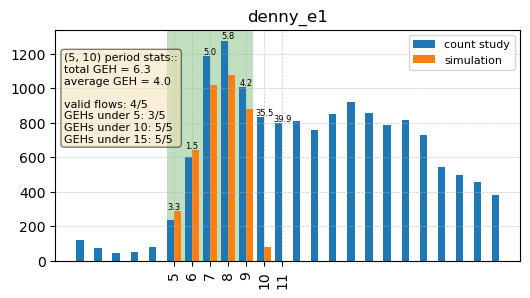

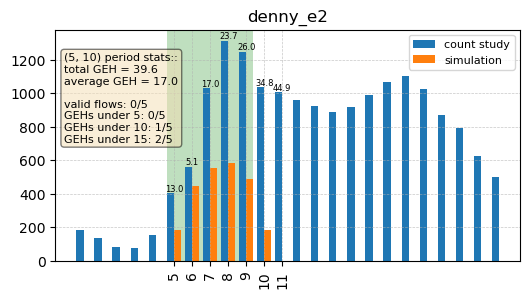

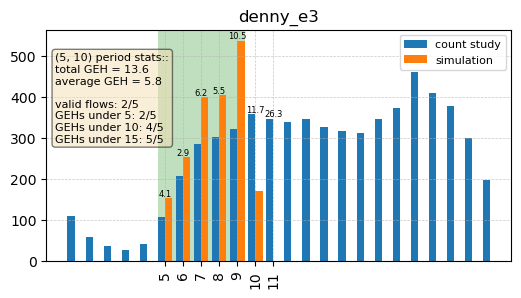

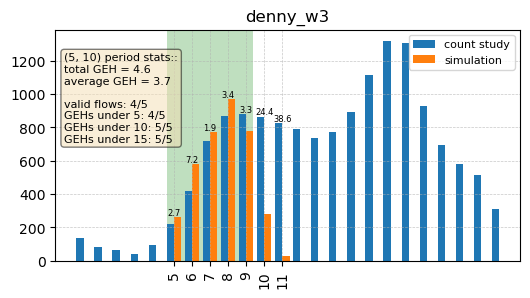

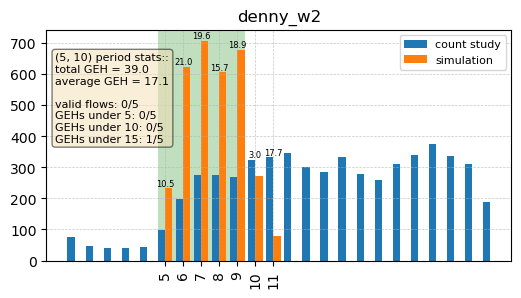

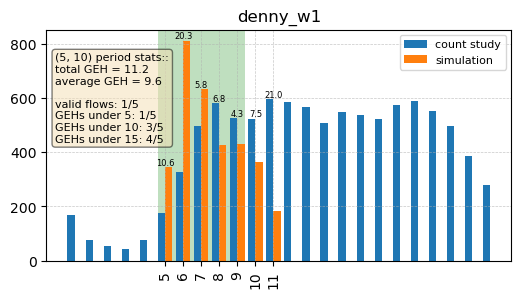

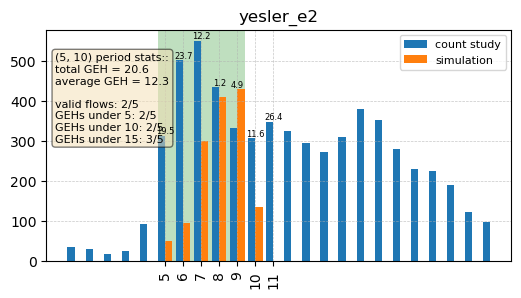

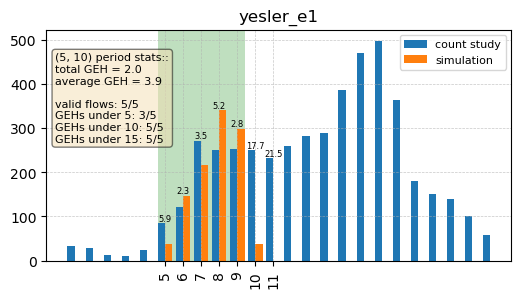

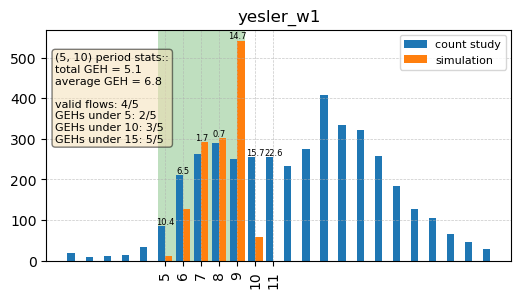

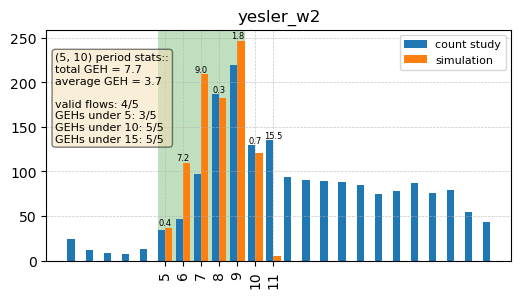

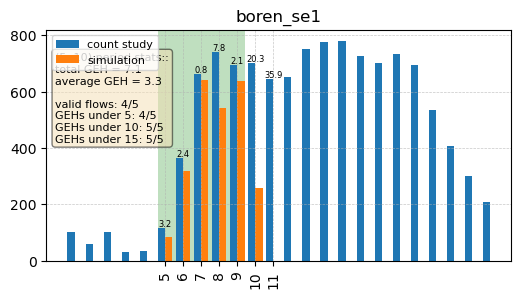

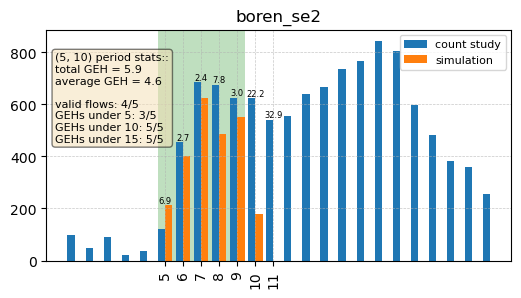

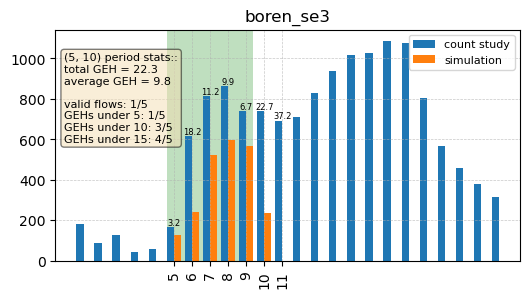

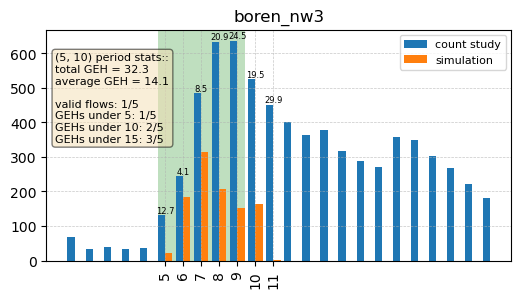

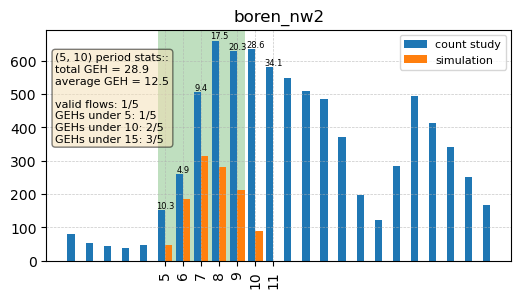

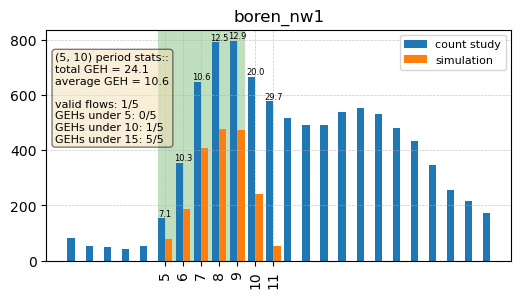

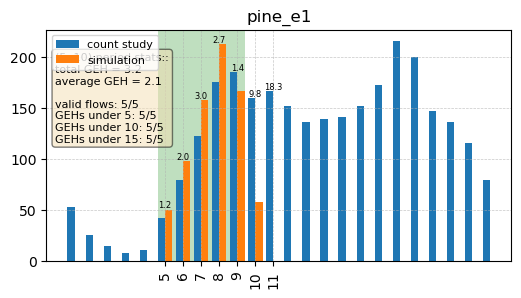

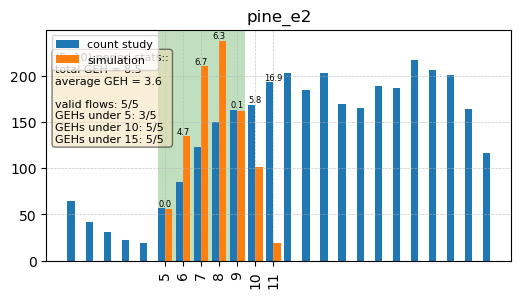

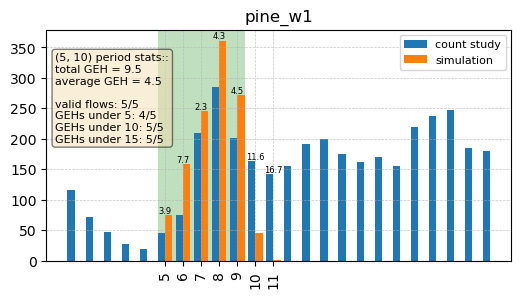

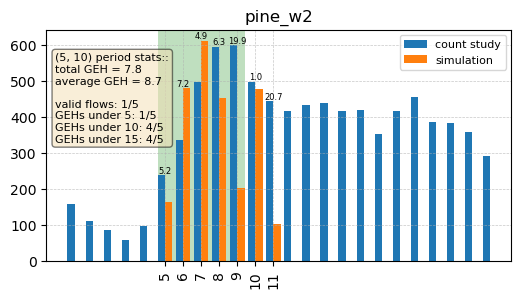

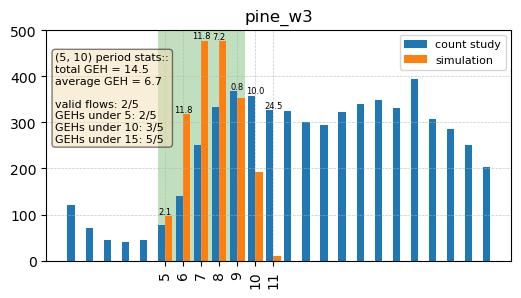

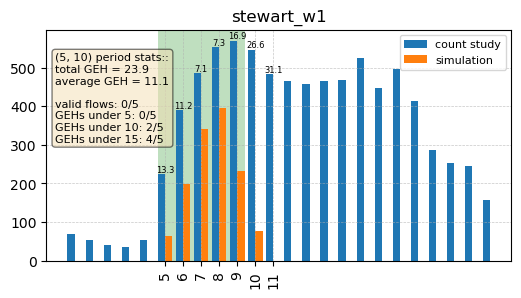

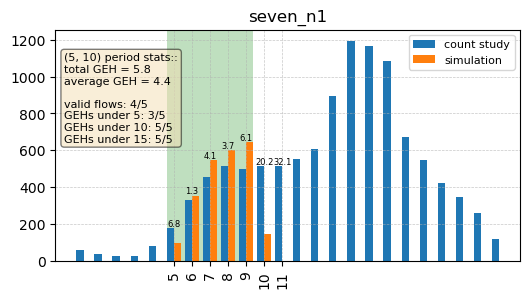

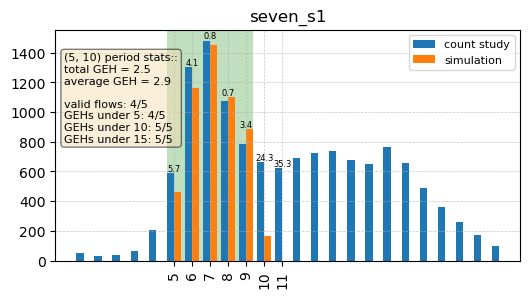

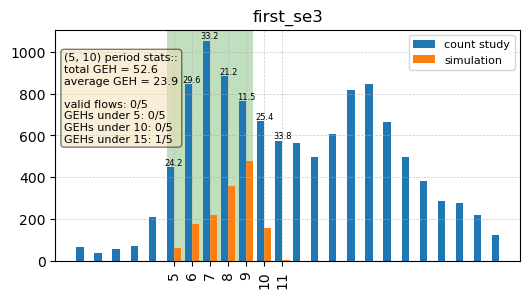

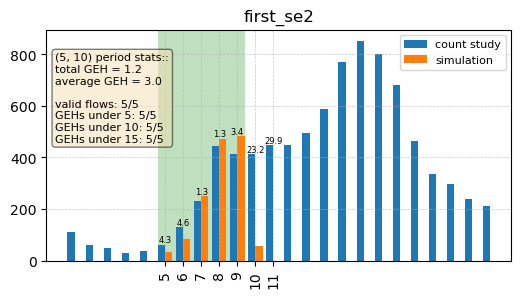

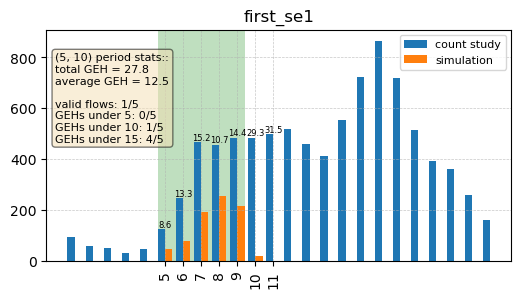

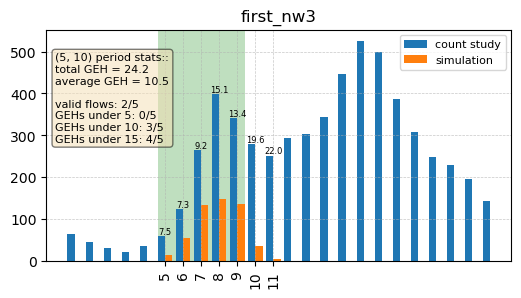

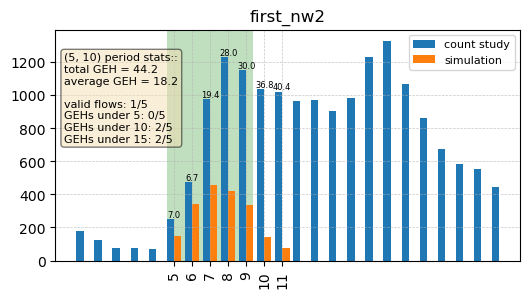

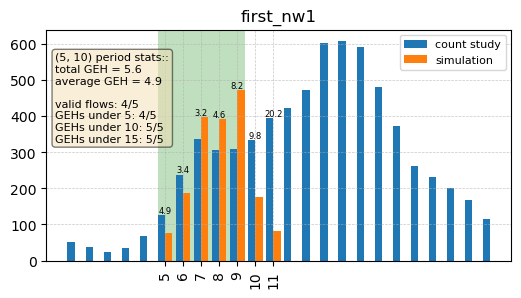

In [15]:
for c in corridor_study_dict.keys():
    count_studies_loops = get_count_study(c, corridor_check=True)
#     draw_barplot(count_studies_loops, c)
    simulation_loops = get_simulation_loop_data(loopKey=c)[0]
    draw_barplot(count_studies_loops, title=c, label='count study', 
                 dictData2=simulation_loops, label2='simulation', start_end=(start_hour, end_hour),
                show_stats=True)


# in-network calibration

##### first run the simulation with the data generated in the previous out_of_network calibration
##### then look at vehroute output: when you want to reduce the demand in a specific corridor, you look at the trips that actually used this corridor (edge) 
##### then you decide to delete or synthesise sampled trips in a specific hour. But the changes should be in the output of od2trips demand generation tool from the results of this file

In [27]:
demand_tree = ET.parse('alaskanway_od2trips_psrc_vehicle_trips_converted_taz_calibrated_V2.rou.xml')
demand_root = demand_tree.getroot()

route_output =  ET.parse('Mar13 base simulation/vehroute_output.xml').getroot().findall('vehicle')
route_df = []
for vehicle in tqdm(route_output):
    route = vehicle.find('route')
    ID = vehicle.get('id')
#     tripElement = demand_root.find(f'.//trip[@id="{ID}"]')
    depart = float(vehicle.get('depart'))
    vehicle_data = {'id': ID,'depart': depart}   
    if route is None:
        # looking at last routes
        vehicle_data['edges'] = vehicle.find('routeDistribution').findall('route')[-2].get('edges').split(' ')
    else:
        vehicle_data['edges'] = route.get('edges').split(' ')
#     if tripElement is not None:
#         vehicle_data['otaz'], vehicle_data['dtaz'] = (tripElement.get('fromTaz')), (tripElement.get('toTaz'))
    route_df.append(vehicle_data)

    
# Create DataFrame
route_df = pd.DataFrame(route_df)

100%|██████████████████████████████████████████████████████████████████████| 211135/211135 [00:01<00:00, 108693.69it/s]


In [28]:
route_df

,id,depart,edges
0,129,18001.2,"[332068575#0, 332068575#1, 332068575#2, 332068575#3, 22759218#1, 240566654#0, 240566654#1, -6521322#7, -6521322#6, -6521322#4, -6521322#3, -6521322#2, -6521322#1, -6521322#0, 263689011#8]"
1,2256,18030.0,"[45302351, 391470504, -179222050#6, -179222050#4, 179222052, -179222052]"
2,2251,18042.5,"[-668313611#1, -512062503#0, 179222050#1, 179222050#3, 179222050#4, 179222050#5]"
3,5,18055.7,"[-158882517#0, -158882558#0, -621283354, 428098985]"
4,60,18013.6,"[-179222048#1, -42005979#13, -42005979#10, 546110554#1, -591627840#4, -591627840#1, -572049556#3, -572049556#1, 428341307#1, 393047825]"
...,...,...,...
211130,190883,37943.7,"[123889278, 123889278.406, 97130456, 431431042, 4712882, gneE762, 60786858#1, 427907033, -427907030, -427907031, -286940848#0, -427914314, -427915134]"
211131,202355,38759.8,"[123889278, gneE765, 4712862.117, 38008153, 38008152, 15257850, 533110451, 56178980, gneE523, -428227905#0, 191144466#1, 191144466#4, 191144466#6, 428243943#12, 163419189#1, 163419189#1.58, 620595348#1, 620595348#1.46, 580425582#0, 580425582#0.91, 580425578#1, 173554614#0, 580426496#0, 580426496#0.82, 428305118#1, 428305118#1.95, 540076527#1, 540076527#2, 8045788#0, 8045788#2, 8045788#3, 8045788#4, 428248064#1, 215869721#0, 215869721#1, 215869721#2, -460419020#1, -460419020#0, -6405767#8, -6405767#7, -6405767#6, -6405767#5, 351500650#5, 351500650#6, 351500650#7, -239801864#1]"
211132,202982,38023.5,"[123889278, 123889278.406, 97130456, 431431042, 4712882, gneE762, 60786858#1, 427907033, -427907030, -427907031, -286940848#0, -427914314, -427915134]"
211133,190863,37992.7,"[123889278, 123889278.406, 97130456, 431431042, 4712882, gneE762, 60786858#1, 427907033, -427907030, -427907031, -286940848#0, -427914314, -427915134]"


###
### ALWAYS RUN from THIS CELL BEFORE MAKING A NEW DEMAND FILE. 
 

In [29]:
demand_tree = ET.parse('alaskanway_od2trips_psrc_vehicle_trips_converted_taz_calibrated_V2.rou.xml')
demand_root = demand_tree.getroot()
len(demand_root.findall('trip'))

209284

In [30]:
name_edge_dict = {'denny_e1':'332473706#0', 'denny_e2':'428087113#0', 'denny_e3':'436163947#1',
                 'denny_w1':'-436163947#2', 'denny_w2':'-428087113#1', 'denny_w3':'-332473706#1',
                 'yesler_e1':'gneE50', 'yesler_e2':'gneE355', 
                 'yesler_w1':'gneE354', 'yesler_w2':'gneE49',
                  'boren_se1':'240455063#5', 'boren_nw3':'-240455063#5', 'boren_se2':'428231010#0',
                  'boren_nw2':'-428231010#1', 'boren_se3':'428230982#0', 'boren_nw1':'-428230982#0',
                  'pine_e1':'-37551507#1', 'pine_e2':'428246441#1',
                  'pine_w2':'37551507#0','pine_w1':'-428246441#1', 'pine_w3':'8111110#0.68',
                  'stewart_w1':'371267131#2', 
                  'seven_n1':'52840083.93', 'seven_s1':'367069126', 
                  'first_se1':'-351500650#4', 'first_se2':'-428243129#2', 'first_se3':'-610573957#1', 
                  'first_nw1':'610573957#1', 'first_nw2':'428243129#0', 'first_nw3':'351500650#4'
                 }

# change percentage with sampleNumber?
def get_sample(edge_name, hour, percentage, replacement=True, avoid_names=None):
    '''
    returns a list of trip_ids. the list will be used to generate or delete trips
    '''
    edge = name_edge_dict[edge_name]
    sample =  route_df[route_df['edges'].apply(lambda x: edge in x)]
       
    if avoid_names is not None:
        for avoid_name in avoid_names:
            avoid = name_edge_dict[avoid_name]
            sample = sample[sample['edges'].apply(lambda x: avoid not in x)]
    sample = sample[sample['depart']//3600 == hour]
    ### if '_' in sampleID: its a transit demand and we won't touch it
    sample = sample[sample['id'].apply(lambda x: '_' not in x)]
    selected = sample.sample(int(percentage/100*len(sample)), replace=replacement)
    selected.reset_index(drop=True, inplace=True)
    return selected 


counter=1
def get_new_ids(df):
    global counter
    df['org_id'] = df['id']
    df['id'] = df['id']+f'c{counter}:'
    counter +=1
    count_dict = {}
    for index, row in df[df.duplicated(subset=['id'], keep=False)].iterrows():
        count = count_dict.setdefault(row['id'], 1)
        df.loc[index, 'id'] = f"{row['id']}{count}"
        count_dict[row['id']] += 1
    return df


def make_trip(element_to_copy, synthesizedRow):
    new_trip = deepcopy(element_to_copy)
    new_id, new_depart = synthesizedRow['id'], str(synthesizedRow['depart'])
    new_trip.set('id', new_id)
    new_trip.set('depart', new_depart)
    return new_trip


def is_valid(trip_element):
    highways = ['5000', '5001', '5002', '5003', '5004', '5005', '5008', '5009', '5010', '5011']
    if trip_element is None:
        return False
    otaz, dtaz = (trip_element.get('fromTaz')), (trip_element.get('toTaz'))
    if otaz in highways or dtaz in highways:
        return False
    return True



def synthesis(edge_name, hour, percentage, avoid_names=None):
    global counter
    # creating new demand - we won't add trips to/from highways. they were adjusted before. 
    # However, for reduction we might delete soem pTAZ demand
    sample = get_sample(edge_name, hour, percentage, replacement=True, avoid_names=avoid_names).copy() 
    ### adjust time with a normal distritbution (95%CI: -10 minutes:+10minutes)
    time_offset = np.random.normal(loc=0.0, scale=5.1, size=len(sample))
    sample['org_depart'] = sample['depart']
    sample['depart'] = round(sample['depart'] + time_offset*60, 1)
    ### making new IDs and sort based on depart time
    sample = get_new_ids(sample)
    sample.sort_values(by='depart', inplace=True)
    # adding the new demand to the file
    insert_index = 0
    added_trips = 0
    alltrips = demand_root.findall('trip')
    for idx, trip in sample.iterrows():
        orgID = trip['org_id']
        element_to_copy = demand_root.find(f'.//trip[@id="{orgID}"]')
        if is_valid(element_to_copy):
            added_trips += 1
            new_trip_element = make_trip(element_to_copy, trip)          
            for index, element in enumerate(demand_root.findall('trip')):
                if float(element.get('depart')) > float(new_trip_element.get('depart')):
                    insert_index = index
                    break
                else:
                    insert_index = index + 1
            demand_root.insert(insert_index+1, new_trip_element)
    print(f'{counter-1}){edge_name},{hour},{percentage},  avoiding:{avoid_names} done. Added {added_trips} trips.')



def reduction(edge_name, hour, percentage, avoid_names=None):
    sample = get_sample(edge_name, hour, percentage, replacement=False, avoid_names=avoid_names).copy() 
    # reducing the sample from original demand file
    sample = sample.sort_values(by='depart')
    for tripID in list(sample['id']):
        element_to_delete = demand_root.find(f'.//trip[@id="{tripID}"]')
        if element_to_delete is not None:
            demand_root.remove(element_to_delete)
    print(f"reduction {edge_name}, hour {hour}, {percentage}%, avoiding:{avoid_names} done. removed {len(sample)} trips")


In [31]:
synthesis('denny_e1', 7, 30, avoid_names=['denny_e3'])#
synthesis('denny_e1', 8, 20, avoid_names=['denny_e3'])#
synthesis('denny_e1', 9, 20, avoid_names=['denny_e3'])#

synthesis('denny_e2', 5, 200, avoid_names=['denny_e3', 'denny_e1'])
synthesis('denny_e2', 7, 75, avoid_names=['denny_e3'])
synthesis('denny_e2', 8, 75, avoid_names=['denny_e3'])
synthesis('denny_e2', 9, 75, avoid_names=['denny_e3'])

synthesis('yesler_e1', 6, 100, avoid_names=['yesler_e2'])

synthesis('yesler_e2', 5, 200)
synthesis('yesler_e2', 6, 150, avoid_names=['yesler_e1'])
synthesis('yesler_e2', 7, 150, avoid_names=['yesler_e1'])
synthesis('yesler_e2', 8, 50, avoid_names=['yesler_e1'])

synthesis('stewart_w1', 5, 200)
synthesis('stewart_w1', 6, 75)
synthesis('stewart_w1', 7, 50)
synthesis('stewart_w1', 8, 50)
synthesis('stewart_w1', 9, 50)

synthesis('first_nw3', 7, 75, avoid_names=['first_nw1'])
synthesis('first_nw3', 8, 75, avoid_names=['first_nw1'])
synthesis('first_nw3', 9, 75, avoid_names=['first_nw1'])

synthesis('first_nw2', 7, 50, avoid_names=['first_nw1'])
synthesis('first_nw2', 8, 50, avoid_names=['first_nw1'])
synthesis('first_nw2', 9, 50, avoid_names=['first_nw1'])

synthesis('first_se3', 5, 200, avoid_names=['first_se2'])
synthesis('first_se3', 6, 200, avoid_names=['first_se2'])
synthesis('first_se3', 7, 100, avoid_names=['first_se2'])
synthesis('first_se3', 8, 100, avoid_names=['first_se2'])
synthesis('first_se3', 9, 100, avoid_names=['first_se2'])

synthesis('first_se1', 5, 200, avoid_names=['first_se2'])
synthesis('first_se1', 6, 200, avoid_names=['first_se2'])
synthesis('first_se1', 7, 200, avoid_names=['first_se2'])
synthesis('first_se1', 8, 200, avoid_names=['first_se2'])
synthesis('first_se1', 9, 200, avoid_names=['first_se2'])

synthesis('boren_se1', 6, 75)
synthesis('boren_se1', 7, 30)
synthesis('boren_se1', 8, 30)
synthesis('boren_se1', 9, 50)

synthesis('boren_se3', 6, 75, avoid_names=['boren_se1'])
synthesis('boren_se3', 7, 75, avoid_names=['boren_se1'])
synthesis('boren_se3', 8, 75, avoid_names=['boren_se1'])
synthesis('boren_se3', 9, 75, avoid_names=['boren_se1'])


synthesis('boren_nw3', 9, 100)
synthesis('boren_nw3', 8, 100)
synthesis('boren_nw3', 6, 100)

synthesis('pine_e2', 9, 50, ['pine_e1'])

synthesis('seven_s1', 5, 100)
synthesis('seven_s1', 6, 100)

1)denny_e1,7,30,  avoiding:['denny_e3'] done. Added 219 trips.
2)denny_e1,8,20,  avoiding:['denny_e3'] done. Added 154 trips.
3)denny_e1,9,20,  avoiding:['denny_e3'] done. Added 111 trips.
4)denny_e2,5,200,  avoiding:['denny_e3', 'denny_e1'] done. Added 19 trips.
5)denny_e2,7,75,  avoiding:['denny_e3'] done. Added 142 trips.
6)denny_e2,8,75,  avoiding:['denny_e3'] done. Added 117 trips.
7)denny_e2,9,75,  avoiding:['denny_e3'] done. Added 67 trips.
8)yesler_e1,6,100,  avoiding:['yesler_e2'] done. Added 71 trips.
9)yesler_e2,5,200,  avoiding:None done. Added 21 trips.
10)yesler_e2,6,150,  avoiding:['yesler_e1'] done. Added 18 trips.
11)yesler_e2,7,150,  avoiding:['yesler_e1'] done. Added 82 trips.
12)yesler_e2,8,50,  avoiding:['yesler_e1'] done. Added 87 trips.
13)stewart_w1,5,200,  avoiding:None done. Added 38 trips.
14)stewart_w1,6,75,  avoiding:None done. Added 72 trips.
15)stewart_w1,7,50,  avoiding:None done. Added 94 trips.
16)stewart_w1,8,50,  avoiding:None done. Added 128 trips.


In [32]:
len(demand_root.findall('trip'))

213337

In [33]:
reduction('yesler_e2', 9, 20)
reduction('yesler_e2', 9, 50, ['yesler_e1'])

reduction('yesler_w1', 8, 20)
reduction('yesler_w1', 9, 40, ['yesler_w2'])

reduction('yesler_w2', 6, 50, ['yesler_w1'])
reduction('yesler_w2', 7, 50, ['yesler_w1'])
reduction('yesler_w2', 8, 20, ['yesler_w1'])

reduction('denny_w1', 5, 50)
reduction('denny_w1', 6, 50)

reduction('denny_w2', 5, 30)
reduction('denny_w2', 6, 30)
reduction('denny_w2', 7, 40)
reduction('denny_w2', 8, 20)
reduction('denny_w2', 8, 50, avoid_names=['denny_w1', 'denny_w3'])
reduction('denny_w2', 9, 20)
reduction('denny_w2', 9, 50, avoid_names=['denny_w3'])


reduction('denny_e3', 6, 50, avoid_names=['denny_e2'])
reduction('denny_e3', 7, 30, avoid_names=['denny_e2'])
reduction('denny_e3', 8, 30, avoid_names=['denny_e2'])
reduction('denny_e3', 9, 50, avoid_names=['denny_e2'])

reduction('seven_n1', 7, 25)
reduction('seven_n1', 8, 25)
reduction('seven_n1', 9, 40)

reduction('seven_s1', 8, 40)
reduction('seven_s1', 9, 45)

reduction('first_nw1', 8, 40, ['first_nw2'])
reduction('first_nw1', 9, 60, ['first_nw2'])

# reduction('pine_e1', 8, 20)
reduction('pine_e2', 6, 50, ['pine_e1'])
reduction('pine_e2', 7, 50, ['pine_e1'])
reduction('pine_e2', 8, 40)
reduction('pine_e2', 9, 50, ['pine_e1'])


reduction('pine_w1', 9, 75, ['pine_w2'])
reduction('pine_w1', 7, 30)
reduction('pine_w1', 6, 50)
reduction('pine_w1', 5, 30, ['pine_w2'])

reduction('pine_w2', 6, 20)
reduction('pine_w2', 7, 30)
# reduction('pine_w2', 9, 10)

reduction('pine_w3',7, 30)
reduction('pine_w3',8, 50, ['pine_w2'])
reduction('pine_w3',9, 50, ['pine_w2'])

reduction yesler_e2, hour 9, 20%, avoiding:None done. removed 120 trips
reduction yesler_e2, hour 9, 50%, avoiding:['yesler_e1'] done. removed 279 trips
reduction yesler_w1, hour 8, 20%, avoiding:None done. removed 64 trips
reduction yesler_w1, hour 9, 40%, avoiding:['yesler_w2'] done. removed 115 trips
reduction yesler_w2, hour 6, 50%, avoiding:['yesler_w1'] done. removed 35 trips
reduction yesler_w2, hour 7, 50%, avoiding:['yesler_w1'] done. removed 46 trips
reduction yesler_w2, hour 8, 20%, avoiding:['yesler_w1'] done. removed 27 trips
reduction denny_w1, hour 5, 50%, avoiding:None done. removed 249 trips
reduction denny_w1, hour 6, 50%, avoiding:None done. removed 423 trips
reduction denny_w2, hour 5, 30%, avoiding:None done. removed 116 trips
reduction denny_w2, hour 6, 30%, avoiding:None done. removed 221 trips
reduction denny_w2, hour 7, 40%, avoiding:None done. removed 344 trips
reduction denny_w2, hour 8, 20%, avoiding:None done. removed 170 trips
reduction denny_w2, hour 8, 5

In [34]:
len(demand_root.findall('trip'))

205963

In [35]:
c=0
for i in demand_root.findall('trip'):
    if 'c' in i.get('id'):
        print(i.get('id'), i.get('depart'))
        c+=1
c

71c46:3 17941.2
2310c46:1 17953.5
192c13:1 17957.4
2261c46: 17989.7
2121c46:2 18068.3
2270c46: 18086.9
192c13:3 18097.2
2121c46:1 18115.2
167c13:1 18130.2
2269c46: 18148.7
1815c9:2 18167.3
2310c46:3 18245.4
2306c29:2 18340.8
2310c46:2 18342.3
2263c46: 18373.2
1772c24:1 18421.3
1815c9:1 18477.0
71c46:1 18549.7
2306c29:1 18550.2
174c46:1 18584.0
174c46:2 18616.4
5124c46:1 18631.1
2730c13:2 18659.2
71c46:2 18661.4
2603c46:3 18665.8
1772c24:3 18671.9
1758c13: 18680.2
192c13:2 18707.8
5152c46:1 18715.9
167c13:3 18773.8
2306c29:3 18820.0
2619c4:2 18855.5
4625c9:1 18855.9
1772c24:2 18870.7
4862c9:3 18875.1
2603c46:1 18897.8
167c13:4 18901.1
2730c13:4 18923.3
5123c46:1 18931.0
5186c46:2 19003.3
5185c46: 19043.9
2603c46:2 19052.9
5182c29:2 19057.3
4625c9:2 19084.6
5123c46:2 19089.9
5124c46:2 19095.2
4988c46:2 19132.9
5179c29:3 19212.5
8459c46:1 19243.0
5152c46:2 19245.8
4986c46:2 19256.0
4988c46:1 19256.6
2730c13:3 19268.7
5179c29:2 19269.5
4625c9:5 19291.3
4983c46: 19298.6
5151c46: 19330.8
462

4053

In [36]:
demand_tree.write('alaskanway_od2trips_psrc_vehicle_trips_converted_taz_calibrated_V3.rou.xml', encoding='utf-8', xml_declaration=True)
